# Предсказание риска сердечных заболеваний

В данной работе я использую машинное обучение для предсказания риска сердечных заболеваний.
У нас есть файл train.csv с собранными реальными данными о различных показателях, а также о наличии сердечного заболевания. Обучив модель на этих данных я предскажу для файла test.csv (с признаками) вероятность наличия сердечного заболевания. Оценивать будем с помощью метрики ROC-AUC.

# Подготовительные работы

Импортируем необходимые библиотеки и функции, загрузим файлы и проверим, что всё работает.

In [118]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#подключаем все необходимые библиотеки
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from pandas_profiling import ProfileReport
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/yap15-heart-diseases-predictions/sample_submission.csv
/kaggle/input/yap15-heart-diseases-predictions/train.csv
/kaggle/input/yap15-heart-diseases-predictions/test.csv


Загрузим все файлы в переменные, чтобы мы могли с ними работать.

In [2]:
#загружаем данные из файлов
try:
    #sample_submission = pd.read_csv('/kaggle/input/yap15-heart-diseases-predictions/sample_submission.csv')
    train = pd.read_csv('/kaggle/input/yap15-heart-diseases-predictions/train.csv')
    test = pd.read_csv('/kaggle/input/yap15-heart-diseases-predictions/test.csv')
    print('Данные загружены в test, train')
except:
    print('Не удалось загрузить данные')

Данные загружены в test, train


# Проверка и предобработка данных

Взглянем для начала на данные в train, чтобы понять, нужно ли с ними что-то делать.

In [3]:
#ProfileReport(train, title="Profiling Report", html={'style':{'full_width':True}})

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [5]:
train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Данные выглядят целостно и полно. Однако, есть вопрос к колонке age. Это возраст в днях. Для нас колонка не очень информативна, однако, такая детализация гораздо лучше подходит для работы модели. Взглянем на корреляцию признаков

In [6]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,1.000000,0.003457,0.003502,-0.003038,-0.001830,0.003356,-0.002529,0.006106,0.002467,-0.003699,0.001210,0.003755,0.003799
age,0.003457,1.000000,-0.022811,-0.081515,0.053684,0.020764,0.017647,0.154424,0.098703,-0.047633,-0.029723,-0.009927,0.238159
gender,0.003502,-0.022811,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109
height,-0.003038,-0.081515,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821
weight,-0.001830,0.053684,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660
ap_hi,0.003356,0.020764,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475
ap_lo,-0.002529,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719
cholesterol,0.006106,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147
gluc,0.002467,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307
smoke,-0.003699,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486


Рост коррелирует с полом и весом. Пол коррелирует также с курением. Никаких явных аномалий тут нет. Перейдём к предобработке.

В датасетах есть столбец id, который не нужен для машинного обучения, а также дублирует index, поэтому без сожаления можем его удалить, чтобы он не влиял на работу модели, а также мы могли бы найти полные дубликаты. Но сохраним датасет Test с id, т.к. они нам потом понадобятся.

In [7]:
train = train.drop(columns = ['id'], axis=1)
test_temp = test['id']
test = test.drop(columns = ['id'], axis=1)

Проверим на пропуски. Ну вдруг они есть где-то.

In [8]:
train.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Пустых значений нет. Посмотрим, как дела с дубликатами

In [9]:
train.duplicated().sum()

24

Ну, не критично, но лучше удалим их, зачем нам полные дубликаты.

In [10]:
train = train.drop_duplicates()

Проверим-ка выбросы в значениях возраста, веса и роста

count    69976.000000
mean     19468.950126
std       2467.374620
min      10798.000000
25%      17664.000000
50%      19703.000000
75%      21327.000000
max      23713.000000
Name: age, dtype: float64

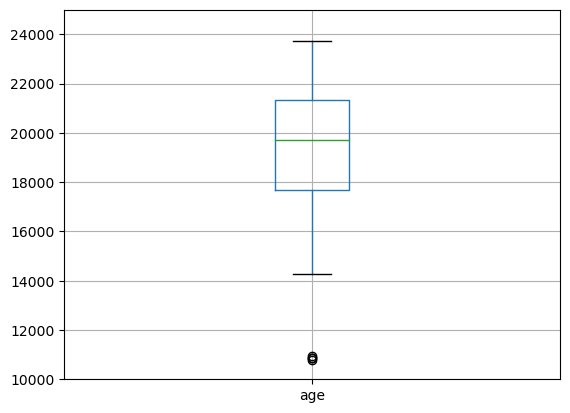

In [11]:
train.boxplot(column=['age'])
plt.ylim(10000,25000)
train['age'].describe()

Есть выбросы в нижней части, около 12000. Т.к. это дни, то это 30-летние люди. Посмотрим, много ли их там, и можем ли мы их удалить.

In [12]:
train[train['age']<12000].value_counts()

age    gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio
10798  2       175     92.0    100    60     1            1     0      0     1       0         1
10859  1       159     59.0    120    80     1            1     0      0     1       0         1
10878  1       175     59.0    120    80     1            1     0      0     1       0         1
10964  1       160     59.0    110    70     1            1     0      0     1       0         1
dtype: int64

4 штуки. Можем пожертвовать ради чистых данных.

In [13]:
Q1 =  train['age'].quantile(0.25)
Q3 = train['age'].quantile(0.75)
IQR = Q3 - Q1
train = train[(train['age'] > Q1-1.5*IQR) & (train['age'] < Q3+1.5*IQR)]

count    69972.000000
mean     19469.441419
std       2466.589297
min      14275.000000
25%      17665.000000
50%      19703.000000
75%      21327.000000
max      23713.000000
Name: age, dtype: float64

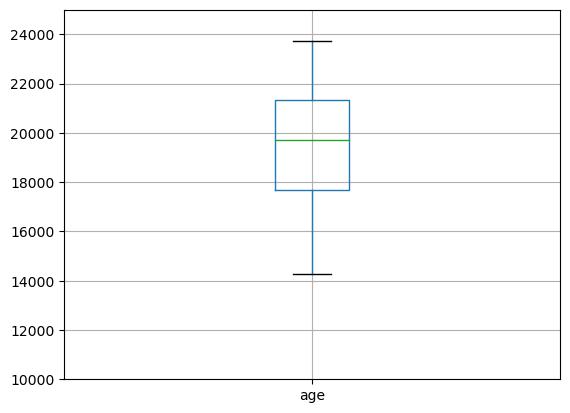

In [14]:
train.boxplot(column=['age'])
plt.ylim(10000,25000)
train['age'].describe()

Посмотрим теперь на давление и что с ним не так.

count    69972.000000
mean        96.637641
std        188.509870
min        -70.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      11000.000000
Name: ap_lo, dtype: float64

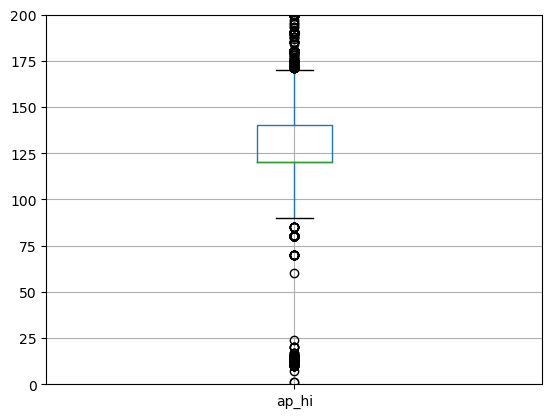

In [15]:
train.boxplot(column=['ap_hi'])
plt.ylim(0,200)
train['ap_lo'].describe()

count    69972.000000
mean        96.637641
std        188.509870
min        -70.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      11000.000000
Name: ap_lo, dtype: float64

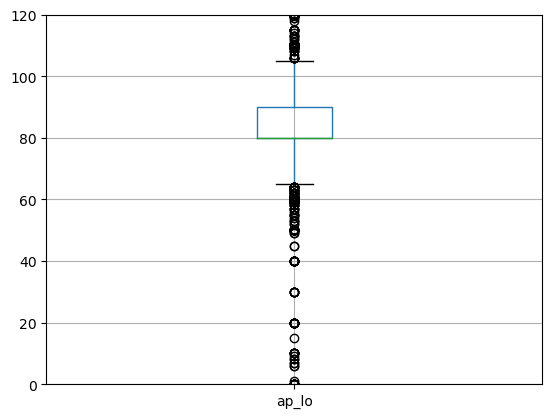

In [16]:
train.boxplot(column=['ap_lo'])
plt.ylim(0,120)
train['ap_lo'].describe()

Какой интересный набор. Тут есть всё: отрицательное давление, слишком большое, слишком маленькое. Поступим так:
* Если давление меньше нуля, возьмём модуль
* Затем, если давление больше 2000, разделим на 100
* Затем, если давление больше 200, но меньше 1000, разделим на 10
* Затем, если давление меньше 30, домножим его на 10
* Затем похожие манипуляции сделаем с ap_hi
* Сравним, если нижнее давление выше верхнего, поменяем их местами

In [17]:
#функция для перевода отрицательных значений в положительные
def absolute(dataset):
    dataset.loc[dataset['ap_lo'] < 0, 'ap_lo'] = abs(dataset.loc[dataset['ap_lo'] < 0, 'ap_lo'])
    dataset.loc[dataset['ap_hi'] < 0, 'ap_hi'] = abs(dataset.loc[dataset['ap_hi'] < 0, 'ap_hi'])

#вызываем функцию для обоих датасетов
absolute(train)
absolute(test)

In [18]:
#отбрасываем лишние два ноля в конце, считаем это ошибочным вводом
def zeros(dataset):
    dataset.loc[dataset['ap_lo'] > 2000, 'ap_lo'] = dataset.loc[dataset['ap_lo'] > 2000, 'ap_lo']/100
    dataset.loc[dataset['ap_hi'] > 2000, 'ap_hi'] = dataset.loc[dataset['ap_hi'] > 2000, 'ap_lo']/100

zeros(train)
zeros(test)

In [19]:
#отбрасываем лишний ноль в конце, считаем это ошибочным вводом
def zero(dataset):
    dataset.loc[(dataset['ap_lo'] >= 200)&(dataset['ap_lo'] <= 2000), 'ap_lo'] = dataset.loc[(dataset['ap_lo'] >= 200)&(dataset['ap_lo'] <= 2000), 'ap_lo']/10
    dataset.loc[(dataset['ap_hi'] >= 200)&(dataset['ap_hi'] <= 2000), 'ap_hi'] = dataset.loc[(dataset['ap_hi'] >= 200)&(dataset['ap_hi'] <= 2000), 'ap_hi']/10

zero(train)
zero(test)

In [20]:
#Если давление меньше 2, умножаем на 100, если меньше 30, умножаем на 10
def toolow(dataset):
    dataset.loc[(dataset['ap_lo'] < 2), 'ap_lo'] = dataset.loc[(dataset['ap_lo'] < 2), 'ap_lo']*100
    dataset.loc[(dataset['ap_hi'] < 2), 'ap_hi'] = dataset.loc[(dataset['ap_hi'] < 2), 'ap_hi']*100
    dataset.loc[(dataset['ap_lo'] < 30), 'ap_lo'] = dataset.loc[(dataset['ap_lo'] < 30), 'ap_lo']*10
    dataset.loc[(dataset['ap_hi'] < 30), 'ap_hi'] = dataset.loc[(dataset['ap_hi'] < 30), 'ap_hi']*10

toolow(train)
toolow(test)

In [21]:
#посмотрим на строки, где нижнее выше верхнего, а так быть не должно
train[train['ap_lo']>train['ap_hi']]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
474,19099,1,156,65.0,120.0,150.0,2,1,0,0,1,0
636,20457,2,169,68.0,70.0,110.0,1,1,0,0,1,0
2384,23361,1,154,102.0,90.0,150.0,1,1,0,0,0,1
2990,21957,2,182,90.0,80.0,140.0,3,3,0,0,1,1
3447,19992,2,180,80.0,80.0,125.0,3,3,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
66657,19498,2,160,81.0,80.0,120.0,3,3,1,1,1,1
67421,23424,1,153,74.0,80.0,130.0,1,1,0,0,1,1
67470,21193,2,172,57.0,80.0,120.0,1,1,1,0,1,1
68067,18421,1,152,65.0,80.0,120.0,1,1,0,0,1,0


In [22]:
#поменяем тут колонки местами
def switchap(dataset):
    dataset['temp_lo'] = dataset['ap_lo']
    dataset['temp_hi'] = dataset['ap_hi']

    dataset.loc[(dataset['temp_lo']>dataset['temp_hi'],'ap_hi')] = dataset.loc[(dataset['temp_lo']>dataset['temp_hi'],'temp_lo')]
    dataset.loc[(dataset['temp_lo']>dataset['temp_hi'],'ap_lo')] = dataset.loc[(dataset['temp_lo']>dataset['temp_hi'],'temp_hi')]

switchap(train)
switchap(test)

#почему-то не удаляет колонки внутри функции, сделаем отдельно
train = train.drop(columns = ['temp_lo'], axis=1)
train = train.drop(columns = ['temp_hi'], axis=1)

test = test.drop(columns = ['temp_lo'], axis=1)
test = test.drop(columns = ['temp_hi'], axis=1)

Отлично! Теперь мы привели все значения давления к адекватным, но у нас могли остаться ноли, а также не очень адекватные значения - выбросы. Заменим выбросы и ноли на медианные значения адекватной части датасета.

In [23]:
train[(train['ap_lo'] == 0) | (train['ap_hi'] == 0)]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
2014,22712,2,167,59.0,90.6,0.0,1,1,0,0,1,0
13489,14965,2,150,60.0,130.0,0.0,1,1,0,0,0,0
16459,20457,1,156,50.0,138.0,0.0,3,1,0,0,1,1
17381,18226,1,164,78.0,138.0,0.0,1,1,0,0,1,0
22923,21182,2,166,68.0,149.0,0.0,1,1,0,0,1,1
23867,16131,1,161,92.0,90.6,0.0,2,1,0,0,1,1
25454,17952,2,176,73.0,120.0,0.0,1,1,0,0,1,0
27686,23396,2,180,73.0,140.0,0.0,1,1,1,1,1,1
31783,16070,1,170,64.0,90.7,0.0,1,1,0,0,1,0
38370,23208,2,170,81.0,148.0,0.0,1,1,0,0,1,0


In [24]:
def median_ap(dataset):
    #ap_lo
    Q1 = dataset['ap_lo'].quantile(0.25)
    Q3 = dataset['ap_lo'].quantile(0.75)
    IQR = Q3 - Q1
    dataset.loc[(dataset['ap_lo'] < Q1-1.5*IQR) | (dataset['ap_lo'] > Q3+1.5*IQR),'ap_lo'] = dataset.loc[(dataset['ap_lo'] > Q1-1.5*IQR) & (dataset['ap_lo'] < Q3+1.5*IQR),'ap_lo'].median()
    #ap_hi
    Q1 = dataset['ap_hi'].quantile(0.25)
    Q3 = dataset['ap_hi'].quantile(0.75)
    IQR = Q3 - Q1
    dataset.loc[(dataset['ap_hi'] < Q1-1.5*IQR) | (dataset['ap_hi'] > Q3+1.5*IQR),'ap_hi'] = dataset.loc[(dataset['ap_hi'] > Q1-1.5*IQR) & (dataset['ap_hi'] < Q3+1.5*IQR),'ap_hi'].median()

median_ap(train)
median_ap(test)

(50.0, 180.0)

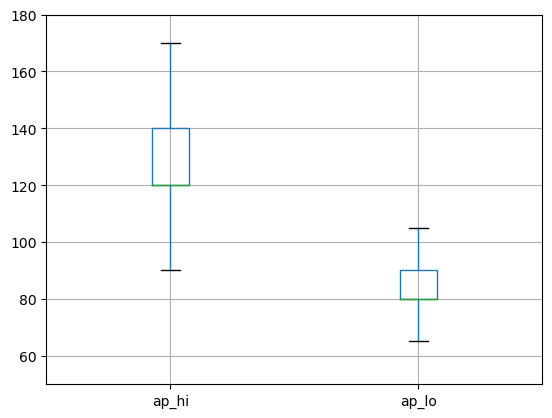

In [25]:
train.boxplot(column=['ap_hi','ap_lo'])
plt.ylim(50,180)

Ну вот теперь красота. Избавились от ошибочно введённых значений. Непонятные аномалии привели к медианам, чтобы не нарушать работу модели. Но проверим ещё один момент. Разницу между систолическим и диастолическим давлением. Она же тоже должна быть адекватной.

In [26]:
train['temp_ap'] = train['ap_hi'] - train['ap_lo']
test['temp_ap'] = test['ap_hi'] - test['ap_lo']

count    69972.000000
mean        44.089307
std         11.866424
min          0.000000
25%         40.000000
50%         40.000000
75%         50.000000
max        103.000000
Name: temp_ap, dtype: float64

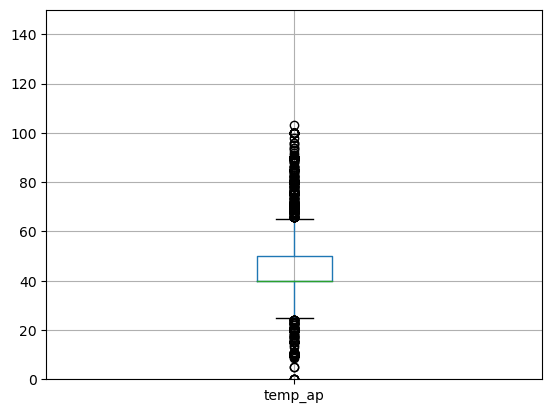

In [27]:
train.boxplot(column=['temp_ap'])
plt.ylim(0,150)
train['temp_ap'].describe()

Нормальная разница у людей должна быть около 40. Меньше 10 и больше 60 - это уже аномалии. Однако, именно разница в 50 и более свидетельствует о проблемах с сердцем. Поэтому, нижние выбросы мы обработаем и заменим на медианные значения верхнего и нижнего давления. А вот верхние оставим до разницы в 80, ибо там могут быть важные показатели.

In [28]:
def median_diff(dataset):
    #ap_lo
    Q1 = dataset['temp_ap'].quantile(0.25)
    Q3 = dataset['temp_ap'].quantile(0.75)
    IQR = Q3 - Q1
    dataset.loc[(dataset['temp_ap'] < Q1-1.5*IQR) | (dataset['temp_ap']>80),'ap_lo'] = dataset.loc[(dataset['temp_ap'] > Q1-1.5*IQR) & (dataset['temp_ap'] < Q3+1.5*IQR),'ap_lo'].median()

    #ap_hi
    Q1 = dataset['temp_ap'].quantile(0.25)
    Q3 = dataset['temp_ap'].quantile(0.75)
    IQR = Q3 - Q1
    dataset.loc[(dataset['temp_ap'] < Q1-1.5*IQR) | (dataset['temp_ap']>80),'ap_hi'] = dataset.loc[(dataset['temp_ap'] > Q1-1.5*IQR) & (dataset['temp_ap'] < Q3+1.5*IQR),'ap_hi'].median()
    #обновляем разницу в давлениях
    dataset['temp_ap'] = dataset['ap_hi'] - dataset['ap_lo']

median_diff(train)
median_diff(test)

count    69972.000000
mean        44.874560
std          9.885272
min         25.000000
25%         40.000000
50%         40.000000
75%         50.000000
max         80.000000
Name: temp_ap, dtype: float64

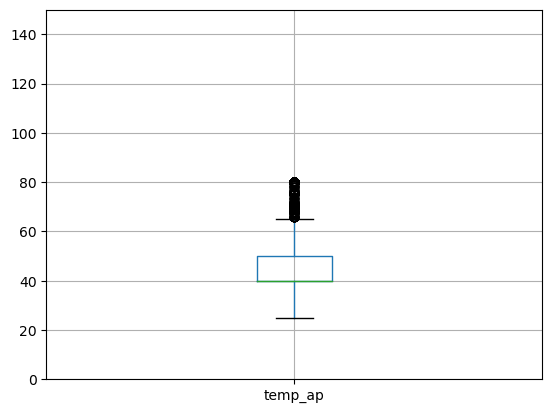

In [29]:
train.boxplot(column=['temp_ap'])
plt.ylim(0,150)
train['temp_ap'].describe()

In [30]:
train = train.drop(columns = ['temp_ap'], axis=1)
test = test.drop(columns = ['temp_ap'], axis=1)

Давление и возраст проверили, теперь выбросов нет или мы знаем, зачем они нужны. 
Посмотрим на рост и вес.

count    69972.000000
mean       164.358986
std          8.211214
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

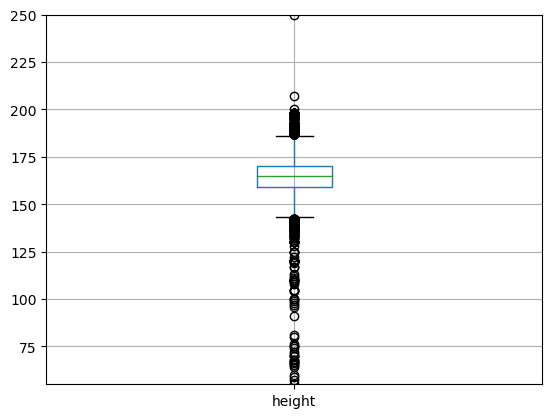

In [31]:
train.boxplot(column=['height'])
plt.ylim(55,250)
train['height'].describe()

Люди высотой менее 147 сантиметров – это карлики, а более 187 см тоже вряд ли встретишь каждый день на улице, то они для нас будут выбросами, и мы от них избавимся в датасете, но с помощью замены на медианные значения адекватной части датасета. Но для начала глянем, не перепутали ли рост и вес?

In [32]:
train[train['height']<train['weight']].head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
389,16718,2,165,169.0,120.0,80.0,1,1,0,0,1,0
435,16765,1,186,200.0,130.0,70.0,1,1,0,0,0,0
2458,23646,2,159,165.0,130.0,70.0,1,1,0,0,0,0
4743,17218,2,176,180.0,140.0,90.0,1,1,0,0,1,1
6153,20990,1,122,161.0,120.0,80.0,1,1,0,0,1,1
7598,14661,2,70,72.0,120.0,80.0,1,1,0,0,1,0
8171,17646,2,97,170.0,160.0,100.0,1,1,1,0,1,1
12435,22077,1,137,161.0,150.0,100.0,2,1,0,0,0,1
12770,19594,1,75,168.0,120.0,80.0,1,1,1,0,1,1
15366,17405,1,125,167.0,120.0,90.0,1,2,0,0,1,1


Есть немножко. Поменяем их местами, чтобы затем обработать аномалии.

In [33]:
#поменяем тут колонки местами
def switchhw(dataset):
    dataset['temp_h'] = dataset['height']
    dataset['temp_w'] = dataset['weight']

    dataset.loc[(dataset['temp_w']>dataset['temp_h'],'weight')] = dataset.loc[(dataset['temp_w']>dataset['temp_h'],'height')]
    dataset.loc[(dataset['temp_w']>dataset['temp_h'],'height')] = dataset.loc[(dataset['temp_w']>dataset['temp_h'],'weight')]

switchhw(train)
switchhw(test)

#почему-то не удаляет колонки внутри функции, сделаем отдельно
train = train.drop(columns = ['temp_h'], axis=1)
train = train.drop(columns = ['temp_w'], axis=1)

test = test.drop(columns = ['temp_h'], axis=1)
test = test.drop(columns = ['temp_w'], axis=1)

In [34]:
def anomalyh(data):    
    Q1 = data['height'].quantile(0.25)
    Q3 = data['height'].quantile(0.75)
    IQR = Q3 - Q1
    data.loc[(data['height'] < Q1-1.5*IQR) | (data['height'] > Q3+1.5*IQR), 'height'] = data.loc[(data['height'] > Q1-1.5*IQR) & (data['height'] < Q3+1.5*IQR),'height'].median()
    
anomalyh(train)
anomalyh(test)

Посмотрим на вес, что у нас там.

count    69972.000000
mean        74.196969
std         14.349097
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        186.000000
Name: weight, dtype: float64

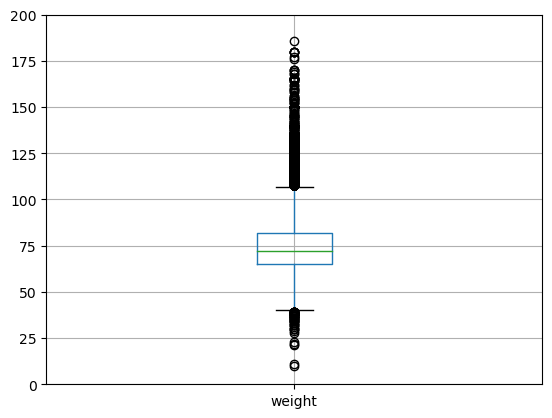

In [35]:
train.boxplot(column=['weight'])
plt.ylim(0,200)
train['weight'].describe()

Выбросы ниже 47 и выше 102 кг. Избавляемся.

In [36]:
def anomalyw(data):    
    Q1 = data['weight'].quantile(0.25)
    Q3 = data['weight'].quantile(0.75)
    IQR = Q3 - Q1
    data.loc[(data['weight'] < Q1-1.5*IQR) | (data['weight'] > Q3+1.5*IQR), 'weight'] = data.loc[(data['weight'] > Q1-1.5*IQR) & (data['weight'] < Q3+1.5*IQR),'weight'].median()
    
anomalyw(train)
anomalyw(test)

Проверим ещё ИМТ, соотношение роста к весу. И аномалии удалим, т.к. сделать с ними больше ничего мы не можем.

In [37]:
train['imt'] = train['weight']/((train['height']/100)**2)

count    69972.000000
mean        27.077470
std          4.584488
min         13.520822
25%         23.833005
50%         26.218821
75%         29.745809
max         50.891795
Name: imt, dtype: float64

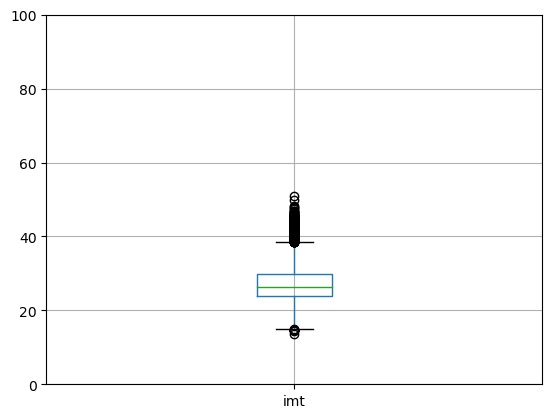

In [38]:
train.boxplot(column=['imt'])
plt.ylim(0,100)
train['imt'].describe()

Есть выбросы в ИМТ. Приведем значения в этих строках к медианным, чтобы не ломать модель.

In [39]:
def median_imt_diff(dataset):
    dataset['imt'] = dataset['weight']/((dataset['height']/100)**2)
    #height
    Q1 = dataset['imt'].quantile(0.25)
    Q3 = dataset['imt'].quantile(0.75)
    IQR = Q3 - Q1
    dataset.loc[(dataset['imt'] < Q1-1.5*IQR) | (dataset['imt']>Q3+1.5*IQR),'height'] = dataset.loc[(dataset['imt'] > Q1-1.5*IQR) & (dataset['imt'] < Q3+1.5*IQR),'height'].median()

    #weight
    Q1 = dataset['imt'].quantile(0.25)
    Q3 = dataset['imt'].quantile(0.75)
    IQR = Q3 - Q1
    dataset.loc[(dataset['imt'] < Q1-1.5*IQR) | (dataset['imt']>Q3+1.5*IQR),'weight'] = dataset.loc[(dataset['imt'] > Q1-1.5*IQR) & (dataset['imt'] < Q3+1.5*IQR),'weight'].median()
    #обновляем разницу в давлениях
    dataset['imt'] = dataset['weight']/((dataset['height']/100)**2)

median_imt_diff(train)
median_imt_diff(test)

#почему-то не удаляет колонки внутри функции, сделаем отдельно
train = train.drop(columns = ['imt'], axis=1)
test = test.drop(columns = ['imt'], axis=1)

Избавились от аномалий и выбросов в данных. Посмотрим, что у нас осталось.

In [40]:
print('Весь объём данных: ',train.shape[0]+test.shape[0], ', потеряли: ', round(100*(100000-(train.shape[0]+test.shape[0]))/100000,2),'%')
print('Процент данных для обучения:', round(100*train.shape[0]/(train.shape[0]+test.shape[0]),2),'%')
print('Процент данных для теста:', round(100*test.shape[0]/(train.shape[0]+test.shape[0]),2),'%')

Весь объём данных:  99972 , потеряли:  0.03 %
Процент данных для обучения: 69.99 %
Процент данных для теста: 30.01 %


При очистке данных потеряли всего 0,03% данных. Можно приступать к разработке и тестированию модели обучения.

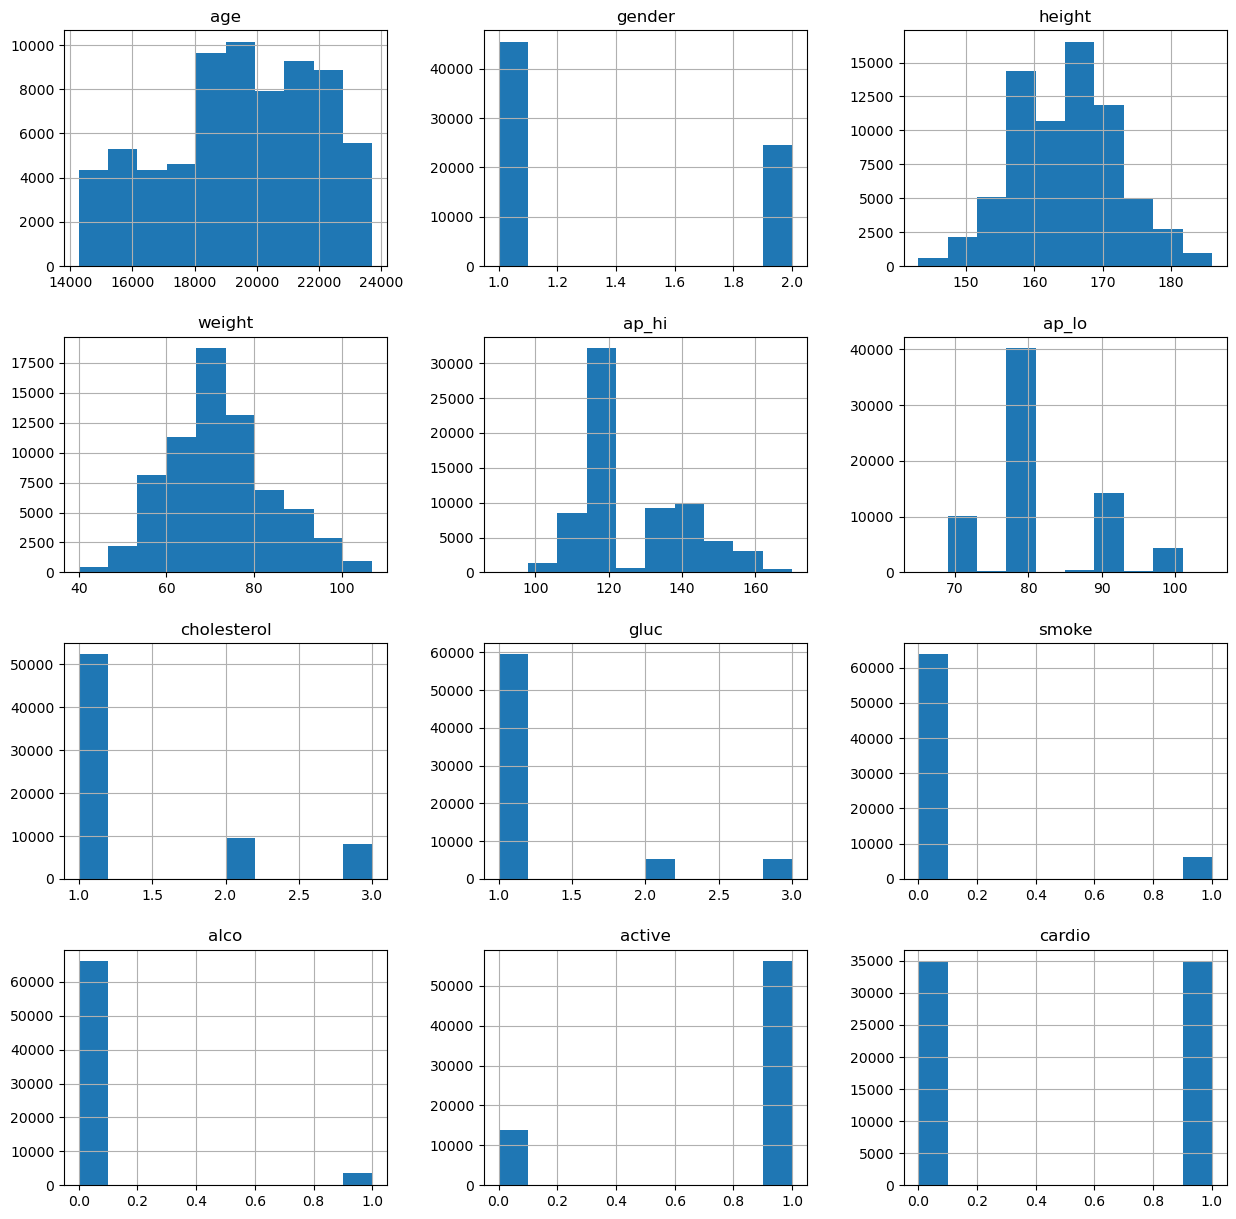

In [41]:
train.hist(figsize=(15, 15))
plt.show()

# Исследование задачи и разработка модели

У нас тренировочная и тестовая выборка разбита в соотношении 70 на 30. Это приемлемое разбиение. 
В тренировочной мы будем использовать кросс-валидацию с 3-5 складываниями, чтобы найти оптимальные результаты. Протестируем несколько моделей и выберем лучшую.

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69972 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69972 non-null  int64  
 1   gender       69972 non-null  int64  
 2   height       69972 non-null  float64
 3   weight       69972 non-null  float64
 4   ap_hi        69972 non-null  float64
 5   ap_lo        69972 non-null  float64
 6   cholesterol  69972 non-null  int64  
 7   gluc         69972 non-null  int64  
 8   smoke        69972 non-null  int64  
 9   alco         69972 non-null  int64  
 10  active       69972 non-null  int64  
 11  cardio       69972 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 6.9 MB


In [43]:
#Приведем к единому виду категориальные столбцы
def cate(data):
    data['gender'] = data['gender'].map({2: 1, 1: 0})
    data['cholesterol'] = data['cholesterol'].map({3:2, 2: 1, 1: 0})
    data['gluc'] = data['gluc'].map({3:2, 2: 1, 1: 0})
cate(train)
cate(test)

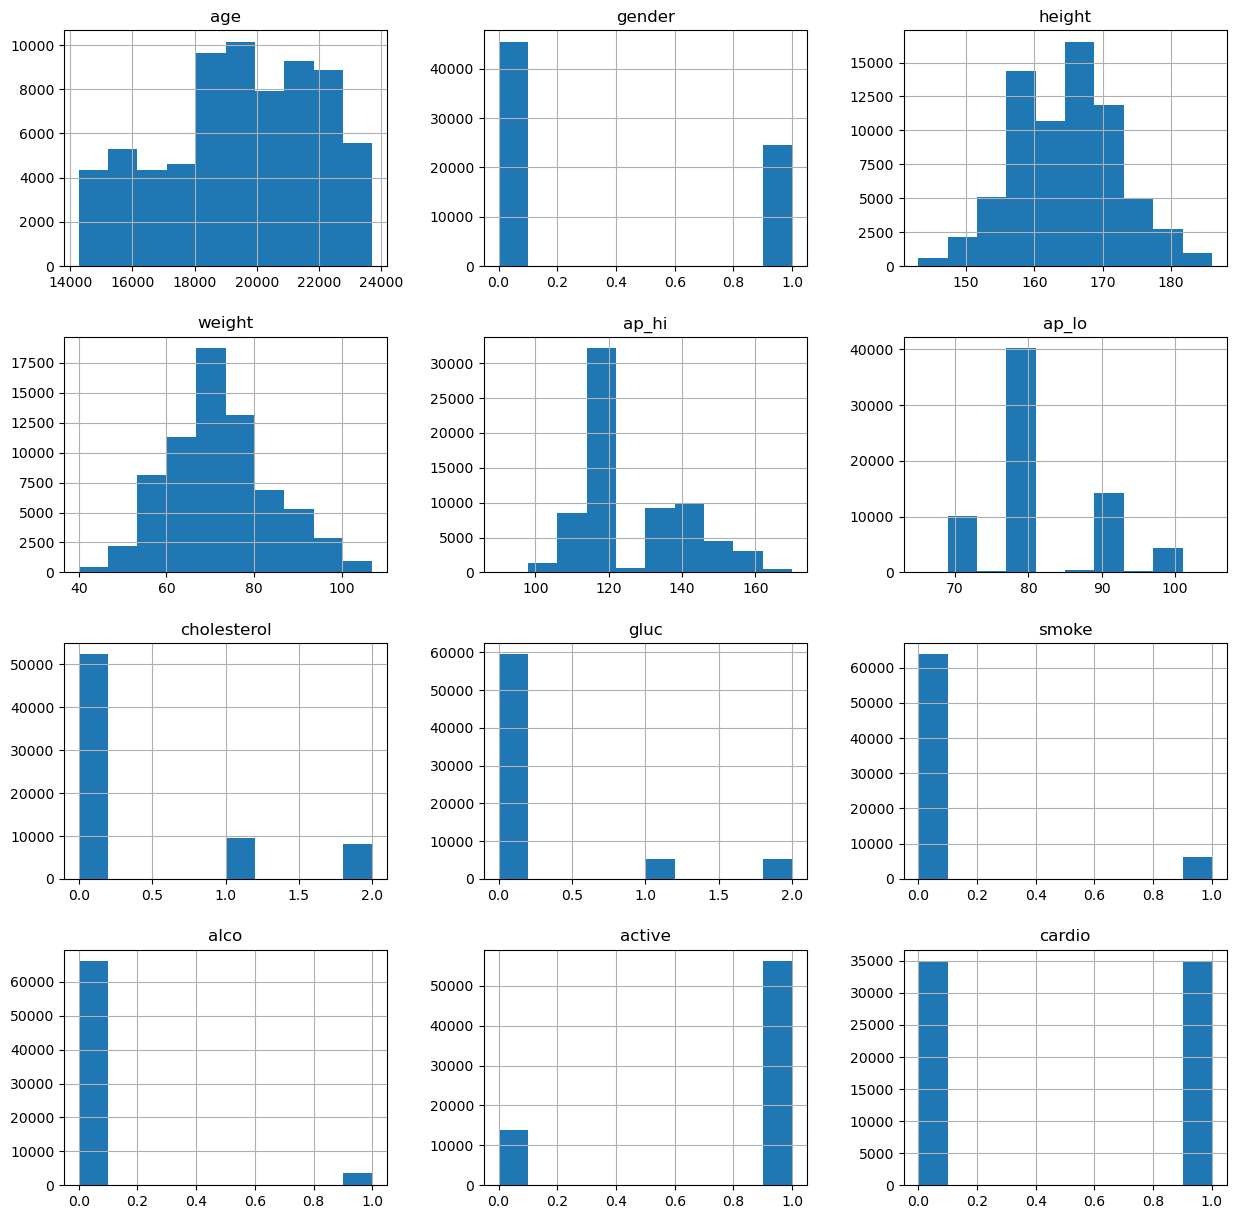

In [44]:
train.hist(figsize=(15, 15))
plt.show()

In [137]:
#разделим на целевой признак и свойства
target = train['cardio']
features = train.drop(['cardio'] , axis=1)

In [138]:
features.to_csv('/kaggle/working/features.csv',sep=',')

In [46]:
features.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,18393,1,168.0,62.0,110.0,80.0,0,0,0,0,1
1,20228,0,156.0,85.0,140.0,90.0,2,0,0,0,1
2,18857,0,165.0,64.0,130.0,70.0,2,0,0,0,0
3,17623,1,169.0,82.0,150.0,100.0,0,0,0,0,1
4,17474,0,156.0,56.0,120.0,80.0,0,0,0,0,0


In [47]:
print('Размер train:',features.shape[0],round(100*features.shape[0]/(train.shape[0]+test.shape[0]),2),'%')
print('Размер test:',test.shape[0],round(100*test.shape[0]/(train.shape[0]+test.shape[0]),2),'%')

Размер train: 69972 69.99 %
Размер test: 30000 30.01 %


Отлично. Теперь у нас есть выборка для разработки модели и тестовый датасет.

У нас есть два типа признаков. С числовыми произведем масштабирование, к категориальным применим OHE

In [50]:
test_backup = test

In [79]:
#numeric = ['age', 'height', 'weight', 'ap_hi', 'ap_lo'] #остальные параметры скорее boolean
numeric = ['age', 'ap_hi', 'ap_lo', 'height', 'weight']
categorical = ['gender','cholesterol','gluc', 'smoke','alco','active']

In [109]:
#масштабируем числовые значения
scaler = RobustScaler()
scaler.fit(features[numeric])

features[numeric] = scaler.transform(features[numeric])
test[numeric] = scaler.transform(test[numeric])

In [110]:
features

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,-0.357728,1,0.3,-0.666667,-0.50,0.0,0,0,0,0,1
1,0.143364,0,-0.9,0.866667,1.00,1.0,2,0,0,0,1
2,-0.231021,0,0.0,-0.533333,0.50,-1.0,2,0,0,0,0
3,-0.567996,1,0.4,0.666667,1.50,2.0,0,0,0,0,1
4,-0.608684,0,-0.9,-1.066667,0.00,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69995,-0.126434,1,0.3,0.266667,0.00,0.0,0,0,1,0,1
69996,0.791371,0,-0.7,0.000000,1.00,1.0,1,1,0,0,1
69997,-0.173949,1,1.8,2.200000,0.00,1.0,2,0,0,1,0
69998,0.744948,0,-0.2,0.000000,0.75,0.0,0,1,0,0,0


In [111]:
#кодируем категориальные столбцы
features = pd.get_dummies(features, columns=categorical)
test = pd.get_dummies(test, columns=categorical)

In [112]:
features.head()

,age,height,weight,ap_hi,ap_lo,gender_0,gender_1,cholesterol_0,cholesterol_1,cholesterol_2,gluc_0,gluc_1,gluc_2,smoke_0,smoke_1,alco_0,alco_1,active_0,active_1
0,-0.357728,0.3,-0.666667,-0.5,0.0,0,1,1,0,0,1,0,0,1,0,1,0,0,1
1,0.143364,-0.9,0.866667,1.0,1.0,1,0,0,0,1,1,0,0,1,0,1,0,0,1
2,-0.231021,0.0,-0.533333,0.5,-1.0,1,0,0,0,1,1,0,0,1,0,1,0,1,0
3,-0.567996,0.4,0.666667,1.5,2.0,0,1,1,0,0,1,0,0,1,0,1,0,0,1
4,-0.608684,-0.9,-1.066667,0.0,0.0,1,0,1,0,0,1,0,0,1,0,1,0,1,0


Конечно, возраст не может быть отрицательным, как и другие параметры. Но теперь все наши признаки отмасштабированы и они будут корректно влиять на модель.

Т.к. в результате нам нужно получить бинарный признак (0 или 1) и мы решаем задачу бинарной классификации, то нам подойдёт модель логистической регрессии. Давайте её и попробуем.

In [113]:
try:
    model_LR = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
    model_LR.fit(features, target)
    print('Модель логистической регрессии обучена!')
except:
    print('Модель не обучена, ищи ошибки!')

Модель логистической регрессии обучена!


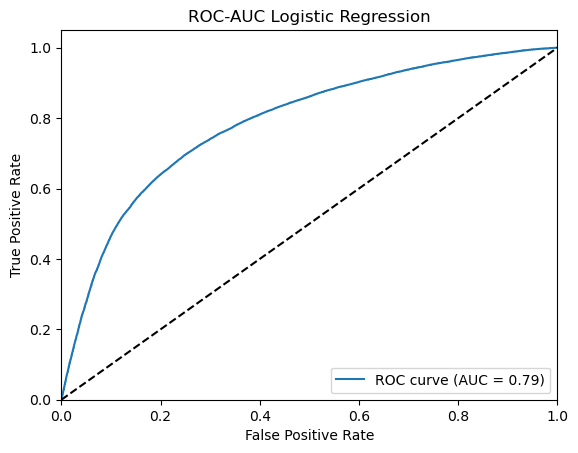

Кросс-валидация ROC AUC: [0.78303482 0.7904299  0.78817401 0.7875705  0.78220444]
Средняя оценка CV 0.7862827331466241


In [114]:
# Generate cross-validated predictions
cv_predictions = cross_val_predict(model_LR, features, target, cv=5, method='predict_proba')

# Calculate the fpr, tpr, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(target, cv_predictions[:, 1])

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# Print the cross-validated ROC AUC score
crv = cross_val_score(model_LR, features, target, cv=5, scoring='roc_auc')
print('Кросс-валидация ROC AUC:', crv)
print('Средняя оценка CV',crv.mean())

Неплохо. Посмотрим, что сумеет сделать модель решающего дерева.

In [ ]:
try:
    model_DTC = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
    model_DTC.fit(features, target)
    print('Модель решающего дерева обучена!')
except:
    print('Модель не обучена, ищи ошибки!')

In [ ]:
# Generate cross-validated predictions
cv_predictions = cross_val_predict(model_DTC, features, target, cv=5, method='predict_proba')

# Calculate the fpr, tpr, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(target, cv_predictions[:, 1])

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC решающего дерева')
plt.legend(loc="lower right")
plt.show()

# Print the cross-validated ROC AUC score
crv = cross_val_score(model_DTC, features, target, cv=5, scoring='roc_auc')
print('Кросс-валидация ROC AUC:', crv)
print('Средняя оценка CV', crv.mean())

Дерево хуже, чем логистическая регрессия. Посмотрим, что умеет делать лес деревьев.

In [ ]:
#здесь были подобраны параметры, которые используются ниже
""" from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split
import numpy as np

# Load dataset
X = features# Your features
y = target # Your target values

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid that you want to search over
param_grid = {'n_estimators': sp_randint(150,300),
              'max_depth': sp_randint(10,20),
              'min_samples_split': sp_randint(2,20),
              'min_samples_leaf': sp_randint(2,20),
              'max_features': ['sqrt', 'log2', None],
              'bootstrap': [True, False],
              'criterion': ['gini','log_loss','entropy'],
              'class_weight' : [None,'balanced_subsample','balanced']}

# Define the randomized search object
random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the randomized search object to the training data
random_search.fit(X, y)

#crv = cross_val_score(random_search, features, target, cv=5, scoring='roc_auc')
#print('Кросс-валидация ROC AUC:', crv)
#print('Средняя оценка CV',crv.mean())

# Print the best hyperparameters found by RandomizedSearchCV
print("Best hyperparameters: ", random_search.best_params_)

# Evaluate the model on the test set using ROC-AUC score
y_pred_proba = random_search.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC score: ", roc_auc) """

In [133]:
#Best hyperparameters:  {'bootstrap': True, 'class_weight': 'balanced', 
#'criterion': 'entropy', 'max_depth': 18, 'max_features': 'log2', 
#            'min_samples_leaf': 18, 'min_samples_split': 18, 'n_estimators': 255}
  
try:
    model_RFC = RandomForestClassifier(random_state=42, criterion='entropy', 
                                       bootstrap=True, max_depth=18, min_samples_leaf=18, max_features='log2', 
                                       min_samples_split=18, n_estimators=255, class_weight='balanced')
    model_RFC.fit(features, target)
    print('Модель случайного леса обучена!')
except:
    print('Модель не обучена, ищи ошибки!')

Модель случайного леса обучена!


In [ ]:
# Generate cross-validated predictions
cv_predictions = cross_val_predict(model_RFC, features, target, cv=5, method='predict_proba')

# Calculate the fpr, tpr, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(target, cv_predictions[:, 1])

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC случайного леса')
plt.legend(loc="lower right")
plt.show()

# Print the cross-validated ROC AUC score
crv = cross_val_score(model_RFC, features, target, cv=5, scoring='roc_auc')
print('Кросс-валидация ROC AUC:', crv)
print('Средняя оценка CV', crv.mean())

Пока что случайный лес даёт лучшую метрику ROC-AUC: 0.794. Но есть методы лучше. Попробуем градиентный бустинг, причём модель XGBoost, она побыстрее обычного бустинга.

In [ ]:
"""#перебор гиперпараметров
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load data
X = features
y = target

# Define objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, step=0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 20, step=1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'gamma': trial.suggest_float('gamma', 0, 1, step=0.1),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10, step=1),
        'objective': 'binary:logistic',
        'random_state': 42,
        'use_label_encoder': False,
        'lambda': trial.suggest_int('lambda', 1, 10, step=1),
        'alpha': trial.suggest_int('alpha', 0, 10, step=1),
    }

    # Define cross-validation strategy
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate model with cross-validation
    score = cross_val_score(
        xgb.XGBClassifier(**params),
        X, y,
        cv=skf,
        scoring='roc_auc'
    ).mean()

    return score

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction='maximize')
with tqdm(total=10) as pbar:
    for i in range(10):
        study.optimize(objective, n_trials=10)
        pbar.update(1)

# Print best parameters and score
print('Best parameters: ', study.best_params)
print('Best score: ', study.best_value) """

In [119]:
#Best parameters:  {'n_estimators': 300, 
#                   'learning_rate': 0.04, 
#                   'max_depth': 4, 
#                   'subsample': 0.5, 
#                   'colsample_bytree': 0.6, 
#                   'gamma': 0.9, 
#                  'min_child_weight': 3, 
#                   'lambda': 7, 
#                   'alpha': 8}
#Best score:  0.7956725055970573 

try:
    model_XGB = xgb.XGBClassifier(random_state=42, 
                                 n_estimators=300,
                                 learning_rate=0.04,
                                 max_depth=4,
                                 subsample=0.5,
                                 colsample_bytree=0.6,
                                 gamma=0.9,
                                 min_child_weight=3,
                                 reg_lambda=7,
                                 reg_alpha=8)
    model_XGB.fit(features, target)
    print('Модель XGBoost обучена!')
except:
    print('Модель не обучена, ищи ошибки!')

Модель XGBoost обучена!


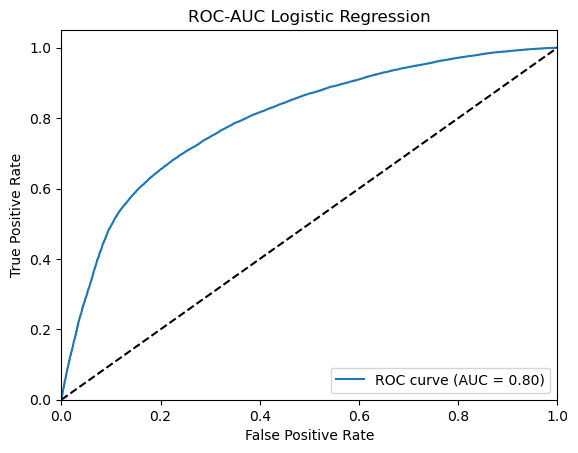

Кросс-валидация ROC AUC: [0.7924462  0.79946996 0.79703049 0.79688612 0.79103562]
Средняя оценка CV 0.7953736757503134


In [120]:
# Generate cross-validated predictions
cv_predictions = cross_val_predict(model_XGB, features, target, cv=5, method='predict_proba')

# Calculate the fpr, tpr, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(target, cv_predictions[:, 1])

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# Print the cross-validated ROC AUC score
crv = cross_val_score(model_XGB, features, target, cv=5, scoring='roc_auc')
print('Кросс-валидация ROC AUC:', crv)
print('Средняя оценка CV',crv.mean())

In [ ]:
#Trial 67 finished with value: 0.7979518160250997 and parameters: 
#        {'n_estimators': 400, 
#         'learning_rate': 0.022146423848864026, 
#         'max_depth': 5, 
#         'subsample': 0.9126670111939009, 
#         'colsample_bytree': 0.6829903824775176, 
#         'gamma': 0.17952253112230904, 
#         'min_child_weight': 6}. 
#        Best is trial 67 with value: 0.7979518160250997.

Модель XGBoost показала себя лучше всего. Её и выбираем для итогового теста.

Оценим важность признаков в финальной модели

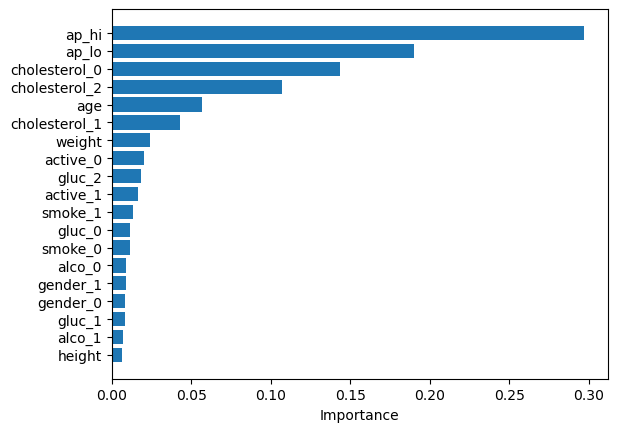

In [122]:
# Get feature importance
importance = model_XGB.feature_importances_

# Sort features by importance score
sorted_idx = importance.argsort()

# Plot feature importance
plt.barh(range(len(importance)), importance[sorted_idx])
plt.yticks(range(len(importance)), features.columns[sorted_idx])
plt.xlabel('Importance')
plt.show()

Кажется, надо обращать внимание на давление, возраст, холестерин и соотношения роста к весу. А вот все остальное не особо влияет на сердечные приступы.

# Подготовка результатов

Модель XGBoost показала себя лучше всего по метрике Roc-Auc. 
Её и используем для финального решения с подобранными идеальными параметрами.

In [ ]:
predicted_test_XBG = model_XGB.predict_proba(test)
predicted_test_XBG = predicted_test_XBG[:,1]
predicted_test_XBG

In [ ]:
submission = pd.DataFrame(columns=['id','cardio'])
submission['cardio'] = predicted_test_XBG
submission['id'] = test_temp

In [ ]:
submission.head()

In [ ]:
submission.info()

In [ ]:
try:
    submission.to_csv('/kaggle/working/submission.csv',sep=',', index=False)
    print('Файл submission.csv создан')
except:
    print('Файл не удалось создать')

Сохраним модель в файл, чтобы затем использовать в steamlit.

In [125]:
import pickle

In [139]:
with open("/kaggle/working/model_XGB.pcl", "wb") as fid:
    pickle.dump(model_XGB,fid)